In [21]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

In [22]:
# load model:
model = YOLO("./runs/detect/train73/weights/best.pt")

In [23]:
# do the prediction with confidence level of maximum 0.2; iou allows for intersection of predicted boxes (lower values are stricter)
def predict(image_path):
    image = cv2.imread(image_path)

    # force model to use cpu even if trained on gpu
    results = model(image, conf=0.05, iou=0.25, device='cpu', classes=1) # 1=cars only for transfer learning model 
    return results[0]

In [24]:
# get image name wihtout extension from path
def extract_image_name(path):
    # Split the path by '/' and get the last part
    image_name = path.split('/')[-1]

    return image_name.replace('.jpg', '')

In [25]:
def test_plot_with_contour(image_path, prediction):
    contours, labels = prediction
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Convert color from BGR to RGB (OpenCV uses BGR by default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot each contour
    counter = 0
    for index, (contour, label) in enumerate(zip(contours, labels)):
        points = np.array(contour, dtype=np.int32)
        if label == 0:
            color = (0, 255, 0)
        else:
            color = (255, 0, 0)
        cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)

    # Display the image with contours
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [26]:
# make the xml code more readable
def prettify_xml(element, indent='  '):
    queue = [(0, element)]  # (level, element)
    while queue:
        level, element = queue.pop(0)
        children = list(element)
        if children:
            element.text = '\n' + indent * (level+1)  # for child open
        if queue:
            element.tail = '\n' + indent * queue[0][0]  # for sibling open
        else:
            element.tail = '\n' + indent * (level-1)  # for parent close
        queue[0:0] = [(level + 1, child) for child in children]

In [27]:
def export_prediction_xml(prediction, image_path, output_path, display_output=False, testing=False, write_xml=True):
    # Create the XML structure
    root = ET.Element("parking", id=image_path)
    contours =  []
    labels = []
    id_counter = 1
    for box in prediction.boxes:
        #create the <space> which equals to one parking spot
        label = int(box.cls.item())
        space = ET.SubElement(root, "space", id=str(id_counter), occupied=str(label), confidence=str(round(box.conf[0].item(), 4)))
        
        # get the cords in xywh format
        cords = box.xywh[0].tolist()
        x, y, w, h = [round(x) for x in cords]
        
        # get the cords in xyxy format
        cords = box.xyxy[0].tolist()
        x1, y1, x2, y2 = [round(x) for x in cords]
            
        # Rotated rectangle, that is not rotated - just keeping this for naming convention
        rotated_rect = ET.SubElement(space, "rotatedRect")
        center = ET.SubElement(rotated_rect, "center", x=str(x), y=str(y))
        size = ET.SubElement(rotated_rect, "size", w=str(w), h=str(h))
        
        # Contour
        contour = ET.SubElement(space, "contour")
        ET.SubElement(contour, "point", x=str(x1), y=str(y1))
        ET.SubElement(contour, "point", x=str(x2), y=str(y1))
        ET.SubElement(contour, "point", x=str(x2), y=str(y2))
        ET.SubElement(contour, "point", x=str(x1), y=str(y2))
        
        contours.append( [(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
        labels.append(label)
        
        id_counter += 1
    
    if write_xml==True:    
        # Format XML for readability
        prettify_xml(root)

        # Write to XML file
        tree = ET.ElementTree(root)
        with open(output_path + '/' + extract_image_name(image_path) + '.xml', "wb") as file:
            tree.write(file)

    if display_output==True:
        print("XML file with predictet empty spots and cars created successfully.")
    if testing == True:
        return contours, labels

In [28]:
# define testing images

images = [
    './data/PKLot/PKLot/PUCPR/Rainy/2012-09-16/2012-09-16_07_32_58.jpg',
    './data/PKLot/PKLot/PUCPR/Rainy/2012-10-23/2012-10-23_08_15_50.jpg',
    './data/PKLot/PKLot/UFPR04/Rainy/2013-01-21/2013-01-21_10_25_05.jpg',
    './data/PKLot/PKLot/UFPR04/Rainy/2012-12-15/2012-12-15_16_30_13.jpg',
    './data/PKLot/PKLot/UFPR05/Rainy/2013-03-16/2013-03-16_16_40_12.jpg',
    './data/PKLot/PKLot/UFPR05/Rainy/2013-03-20/2013-03-20_18_10_14.jpg'
]    
'''
    './data/unseen_test/test1.jpg',
    './data/unseen_test/test2.jpg',
    './data/unseen_test/test3.jpg',
    './data/unseen_test/test4.jpg',
    './data/unseen_test/test5.jpg',
    './data/unseen_test/test6.jpg'
'''

"\n    './data/unseen_test/test1.jpg',\n    './data/unseen_test/test2.jpg',\n    './data/unseen_test/test3.jpg',\n    './data/unseen_test/test4.jpg',\n    './data/unseen_test/test5.jpg',\n    './data/unseen_test/test6.jpg'\n"


0: 384x640 5 cars, 286.6ms
Speed: 4.5ms preprocess, 286.6ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


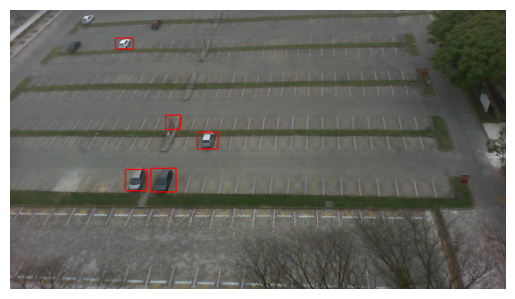


0: 384x640 230 cars, 229.2ms
Speed: 2.5ms preprocess, 229.2ms inference, 6.0ms postprocess per image at shape (1, 3, 384, 640)


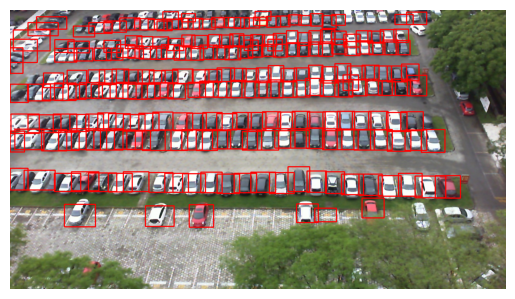


0: 384x640 52 cars, 267.2ms
Speed: 1.5ms preprocess, 267.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


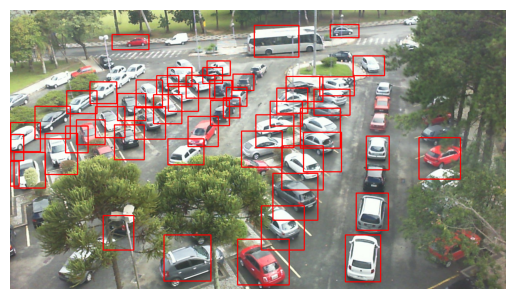


0: 384x640 1 car, 232.2ms
Speed: 1.0ms preprocess, 232.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


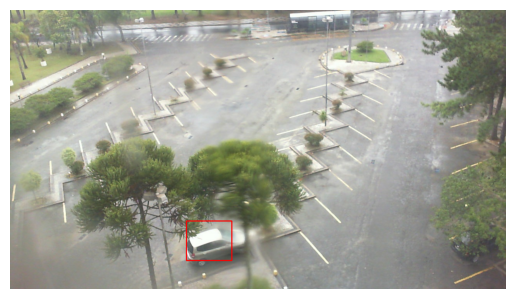


0: 384x640 6 cars, 230.8ms
Speed: 2.0ms preprocess, 230.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


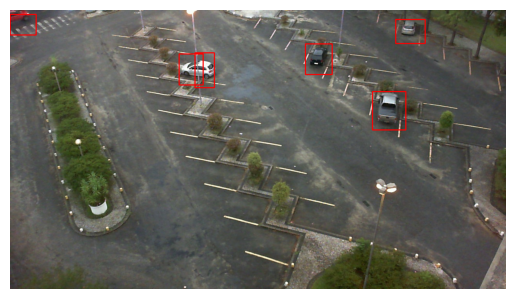


0: 384x640 40 cars, 302.1ms
Speed: 2.0ms preprocess, 302.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


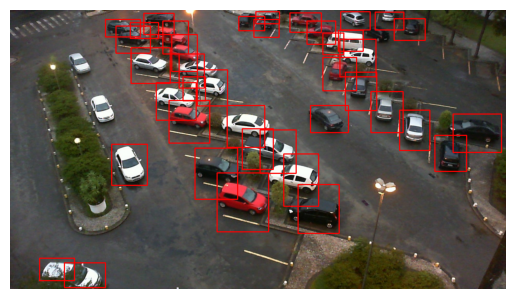

In [29]:
# adjust this to your data structure:
# image_path = './data/PKLot/PKLot/PUCPR/Rainy/2012-10-23/2012-10-23_08_15_50.jpg'
output_path = './data/detection/xml_files'

for image_path in images:
    prediction = predict(image_path)
    test_plot_with_contour(image_path, export_prediction_xml(prediction, image_path, output_path, testing=True))

In [30]:
#prediction = predict(image_path)